# Finding a recipe to the "Secret Sauce" of Quantum Computing
**An IQuHACK 2026 IQM Challenge Submission by Steven Jaime Salazar, Justin Zou, Cameron Zuschmidt, Yuzhe Pan & Bhargav Yerramsetty**

### How quantum computers do more than classical ones

**What is the goal of this section?**

Our goal here is to explain what superposition is, how it differs from classical randomness, and why it enables quantum advantage.
And then, we will show how to *prove* when superposition is really present.


## Classical bit vs Quantum bit

A **classical bit** can be:
- `0`
- `1`

A **quantum bit (qubit)** can be:
$$ 
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
 $$
where:
$$
|\alpha|^2 + |\beta|^2 = 1
$$

...and this is also known as a **superposition** of `|0⟩` and `|1⟩`.

(Note that a qubit can exist in *both* states at once until we measure it.)


## Intuition: Not just randomness

A coin flip is random, but a qubit is not just random because it has **phase** and **interference**.

A classical mixture will consist of a:
- 50% chance of 0
- 50% chance of 1

But a quantum superposition will have:
$$
|\psi\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$
This looks like a coin flip when measured…
but behaves *very differently* when combined with other operations.


## ...but Superposition is not enough

At first glance, superposition already seems weirdly powerful:

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
$$

But there is a catch, because if we prepare two qubits independently, we obtain:

$$
(|0\rangle + |1\rangle) \otimes (|0\rangle + |1\rangle)
$$

Which upon closer inspection, still is only a product of two single-qubit states.

Such states can always be explained as:

• independent quantum systems  
• no non-classical correlations  
• efficiently simulable  

Which, unfortunately, means that superposition alone cannot explain quantum advantage.

So, it's about time we get to the sauce of all of this: Entanglement!

## From a superposition to entanglement

An entangled state is one that **cannot** be written as a product of individual qubit states, so for example:

$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

But there also exists no single-qubit states $|\psi_1\rangle$, $|\psi_2\rangle$ such that:

$$
|\Phi^+\rangle = |\psi_1\rangle \otimes |\psi_2\rangle
$$

Which means that the qubits do not have independent states, measurement outcomes that are correlated, and no classical randomness can reproduce the statistics, all definitions of what Einstein called *“spooky action at a distance.”*


## The experimental challenge

We shall now face the curmudgeon’s question:

> If I gave you a box of qubits, how do you know they are entangled?

Our task is to construct experiments whose outcomes cannot come from classical randomness & from separable quantum states, and must come ONLY from entangled quantum states

In other words, we must **certify entanglement from measurement data alone**. (or, that's what we aim to do, at least.)


## The first entanglement experiment: Bell states

We shall begin with the simplest nontrivial case of two qubits provided to us by IQM Quantum Computers:

$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

and then design measurements in accordance to this equation to show that the statistics it produces violate classical explanations and that its correlations cannot arise from separable states in order to scale up to larger-qubit systems.

In this state, each qubit individually appears random and the two qubits are perfectly correlated, but as a consequence this state **cannot** be written as a product:

$$
|\Phi^+\rangle \neq |\psi_1\rangle \otimes |\psi_2\rangle
$$

so our goal will have to be reached experimentally using only measurement data.

Our circuit will consist of a single Hadamard gate on qubit 0 to facilitate superposition and a CNOT gate to cause entanglement:

$$
|00\rangle \xrightarrow{H \otimes I} \frac{|00\rangle + |10\rangle}{\sqrt{2}}
\xrightarrow{\text{CNOT}} \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

In [12]:
# An IQM Token is needed to run all code blocks

from iqm.qiskit_iqm import IQMProvider

token = input("Enter your IQM token: ")

provider = IQMProvider(
    "https://resonance.meetiqm.com/",
    quantum_computer="emerald", 
    token=token
)

backend = provider.get_backend()
backend


In [13]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc


## Measurements in the Z basis

We will now use the previous simple circuit measure both qubits in the computational (Z) basis. If the state were separable, we would expect independent outcomes, so instead we will test for correlations.


In [14]:
from qiskit import transpile

qc_z = qc.copy()
qc_z.measure_all()

tqc_z = transpile(qc_z, backend=backend, optimization_level=3)
job_z = backend.run(tqc_z, shots=2000)
result_z = job_z.result()
counts_z = result_z.get_counts()

counts_z

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

{'11': 929, '00': 984, '01': 22, '10': 65}

The Z-basis results show near-perfect correlation between the two qubits (with a small amount of leakage into 01/10 from noise & readout errors), however, classical correlation alone is not sufficient to prove entanglement, which leads us to test coherence in a second basis.

## Measurements in the X basis & Correlations

We begin with using the same circuit in the X basis


In [15]:
qc_x = qc.copy()
qc_x.h(0)
qc_x.h(1)
qc_x.measure_all()

tqc_x = transpile(qc_x, backend=backend, optimization_level=3)
job_x = backend.run(tqc_x, shots=2000)
result_x = job_x.result()
counts_x = result_x.get_counts()

counts_x

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

{'11': 911, '00': 985, '01': 30, '10': 74}


We now compute the correlation observables:

$$
\langle Z_0 Z_1 \rangle, \quad \langle X_0 X_1 \rangle
$$

with:

In [16]:
def exp_zz(counts, shots=2000):
    total = 0
    for bitstring, c in counts.items():
        # rightmost bit = qubit 0 in Qiskit
        b0 = int(bitstring[-1])
        b1 = int(bitstring[-2])
        val = 1 if (b0 ^ b1) == 0 else -1
        total += val * c
    return total / shots

zz = exp_zz(counts_z)
xx = exp_zz(counts_x)

zz, xx

(0.913, 0.896)

For the Bell state, quantum theory will predict that

$$
\langle Z_0 Z_1 \rangle = 1, \quad \langle X_0 X_1 \rangle = 1.
$$

Which allows us to combine these into an entanglement *witness* as:

$$
W = \langle Z_0 Z_1 \rangle + \langle X_0 X_1 \rangle.
$$

For across all the separable two-qubit states:

$$
W \le 1.
$$


In [17]:
W = zz + xx
W


1.8090000000000002

Since the measured value violates the separable bounds we've set, we may conclude that the qubits are entangled based only on measurement data, and that no assumption about state preparation was required. 

## The n-qubits entanglement experiment: GHZ Gate with a Stabilizer Witness


The intution starts off from the well-known bell states:
\begin{align*}
   |\phi^+\rangle &= \frac{|00\rangle + |11\rangle}{\sqrt{2}}\\
   |\phi^-\rangle &= \frac{|00\rangle - |11\rangle}{\sqrt{2}}\\
   |\psi^+\rangle &= \frac{|01\rangle + |10\rangle}{\sqrt{2}}\\
   |\psi^-\rangle &= \frac{|01\rangle - |10\rangle}{\sqrt{2}}\\
\end{align*}


These are the well-known double-qubit entangled superpositions. It can be shown that there does not exist single-qubit superpositions $|\psi_1\rangle,|\psi_2\rangle$ such that any of $|\phi^+\rangle, |\phi^-\rangle, |\psi^+\rangle$, and $|\psi^-\rangle$ can be factored into the form $|\psi_1\rangle \otimes |\psi_2\rangle$.


Specifically for $|\phi^+\rangle$ and $|\phi^-\rangle$, it is easy to see that the pattern can indefinitely extend to a higher number $n$ of qubits, as superpositions of the form
\begin{align*}
   \alpha|x^{\otimes n}\rangle + \beta|y^{\otimes n}\rangle
\end{align*}
where $n\in\mathbb{Z}$ such that $n \geq 2$, $|\alpha|^2 + |\beta|^2 = 1$, and $x$ and $y$ are states, can not be factored. That is, no qubit state, not even multi-qubit states, can be factored out.


The Greenberger–Horne–Zeilinger (GHZ) State is then of the form
\begin{align*}
   \frac{\left|0^{\otimes n}\right\rangle + \left|1^{\otimes n}\right\rangle}{\sqrt{2}}
\end{align*}
where $n$ is the number of qubits.

Our goal is to design a entanglement witness for GHZ scaling with system size to show that superpositions of this form are indeed entangled.

Fidelity is a measure of accuracy and reliability for resulting states from a superposition given errors. It is scaled between 0 and 1. The formula for Fidelity $F$ is:
\begin{align*}
F \geq \frac{1}{2}\left( \left\langle X^{\otimes N} \right\rangle + \frac{1}{N - 1}\sum_{i = 1}^{N - 1}\left\langle Z_iZ_{i + 1}\right\rangle\right)
\end{align*}
where $N$ is the total number of qubits used, $\frac{1}{N - 1}\sum_{i = 1}^{N - 1}\left\langle Z_iZ_{i + 1}\right\rangle$ is the average Z-basis measurement and $\left\langle X^{\otimes N} \right\rangle$ is the global coherence (X-basis measurement).

Let $\text{GHZ}_N$ be the GHZ quantum gate for $N$ qubits, where $\text{GHZ}_N\left|0^{\otimes N}\right\rangle = \frac{\left|0^{\otimes n}\right\rangle + \left|1^{\otimes n}\right\rangle}{\sqrt{2}}$.

Let $i\in\mathbb{Z}$ such that $0 \leq i \leq N - 1$. Then, $Z_i = 1$ if the $i$-th resulting qubit state is even (in binary representation). Otherwise, $Z_i = -1$. 

The code used to model our experimental fidelity & to conduct data collection is as shown:

In [21]:
from iqm.qiskit_iqm import IQMProvider

from qiskit import visualization, transpile

def getGhzCircuit(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

def getZZExpectation(counts, i, j, shots):
    exp = 0
    for bitstring, freq in counts.items():
        zi = 1 if bitstring[::-1][i] == '0' else -1
        zj = 1 if bitstring[::-1][j] == '0' else -1
        exp += zi * zj * freq
    return exp / shots

def getGlobalXExpectation(counts, shots):
    exp = 0
    for bitstring, freq in counts.items():
        bits = bitstring.replace(" ", "")
        parity = bits.count('1')
        value = 1 if parity % 2 == 0 else -1
        exp += value * freq
    
    return exp / shots

# qubit num
qBits = 54

qcz = getGhzCircuit(qBits)
qcz.measure_all()

qcx = getGhzCircuit(qBits)
for i in range(qBits):
    qcx.h(i)
qcx.measure_all()

qc_transpiled1 = transpile(qcz, backend=backend)
job_z = backend.run(qc_transpiled1, shots=1024)
result_z = job_z.result()
qc_transpiled2 = transpile(qcx, backend=backend)
job_x = backend.run(qc_transpiled2, shots=1024)
result_x = job_x.result()

# Writing data
with open("zz_expectation.txt", 'w') as file1:
    for i in range(qBits - 1):
        s = f"<Z{i}Z{i+1}>:\t {getZZExpectation(result_z.get_counts(), i, i+1, 1024)}\n"
        file1.write(f"{s}\n")

with open("x_expectations.txt", 'w') as file2:
    s = f"<X^prodN>:\t{getGlobalXExpectation(result_x.get_counts(), 1024)}"
    file2.write(f"{s}\n")

zz_sum = 0
with open("fidelity.txt", 'w') as file3:
    file3.write(f"GHZ Witness Fidelity Lower Bound with {qBits} qubits and 1024 shots\n\n\n")
    file3.write(f"zz_sum = {zz_sum}\n")

    # Calculate Fidelity 
    for i in range(qBits - 1):
        zz_sum += getZZExpectation(result_z.get_counts(), i, i + 1, 1024)
    file3.write(f"zz_sum = {zz_sum}\n")

    zz_avg = zz_sum / (qBits - 1)
    file3.write(f"\n\n\nzz_avg = {zz_avg}\n")

    x_val = getGlobalXExpectation(result_x.get_counts(), 1024)
    file3.write(f"\n\n\nx_val = {x_val}\n")

    # Fidelity
    fidelity_lb = 0.5 * (x_val + zz_avg)
    file3.write(f"\n\n\nfidelity lower bound = {fidelity_lb}\n")

    shots = 1024
counts_z = result_z.get_counts()
counts_x = result_x.get_counts()


print("GHZ Witness Results")
print(f"N qubits: {qBits}")
print(f"Shots:    {shots}")

# ZZ nearest-neighbor expectations
print("\nZ-basis nearest-neighbor correlations <Z_i Z_{i+1}>:")
zz_sum_print = 0.0
for i in range(qBits - 1):
    val = getZZExpectation(counts_z, i, i + 1, shots)
    zz_sum_print += val
    print(f"  <Z{i}Z{i+1}> = {val:.6f}")

zz_avg_print = zz_sum_print / (qBits - 1)
print(f"\nzz_sum = {zz_sum_print:.6f}")
print(f"zz_avg = {zz_avg_print:.6f}")

# Global X expectation
x_val_print = getGlobalXExpectation(counts_x, shots)
print("\nGlobal X coherence:")
print(f"  <X^prodN> = {x_val_print:.6f}")

# 3) Fidelity lower bound
fidelity_lb_print = 0.5 * (x_val_print + zz_avg_print)
print("\nFidelity lower bound:")
print(f"  F_lb = 0.5 * (x_val + zz_avg) = {fidelity_lb_print:.6f}")

# 4) top outcomes in Z basis
print("\nTop 10 Z-basis bitstrings by frequency:")
top_z = sorted(counts_z.items(), key=lambda kv: kv[1], reverse=True)[:10]
for bitstring, freq in top_z:
    print(f"  {bitstring}: {freq}")

print("\nFinished")

Progress in queue:   0%|          | 0/9 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

GHZ Witness Results
N qubits: 54
Shots:    1024

Z-basis nearest-neighbor correlations <Z_i Z_{i+1}>:
  <Z0Z1> = 0.554688
  <Z1Z2> = 0.562500
  <Z2Z3> = 0.375000
  <Z3Z4> = 0.505859
  <Z4Z5> = 0.632812
  <Z5Z6> = 0.673828
  <Z6Z7> = 0.617188
  <Z7Z8> = 0.455078
  <Z8Z9> = 0.361328
  <Z9Z10> = 0.511719
  <Z10Z11> = 0.388672
  <Z11Z12> = 0.414062
  <Z12Z13> = -0.214844
  <Z13Z14> = 0.406250
  <Z14Z15> = 0.351562
  <Z15Z16> = 0.328125
  <Z16Z17> = -0.080078
  <Z17Z18> = 0.599609
  <Z18Z19> = 0.527344
  <Z19Z20> = 0.476562
  <Z20Z21> = 0.468750
  <Z21Z22> = 0.427734
  <Z22Z23> = 0.457031
  <Z23Z24> = 0.341797
  <Z24Z25> = 0.488281
  <Z25Z26> = 0.511719
  <Z26Z27> = 0.259766
  <Z27Z28> = 0.167969
  <Z28Z29> = -0.195312
  <Z29Z30> = 0.210938
  <Z30Z31> = 0.169922
  <Z31Z32> = 0.062500
  <Z32Z33> = -0.082031
  <Z33Z34> = 0.015625
  <Z34Z35> = 0.214844
  <Z35Z36> = 0.460938
  <Z36Z37> = -0.009766
  <Z37Z38> = 0.171875
  <Z38Z39> = 0.476562
  <Z39Z40> = 0.427734
  <Z40Z41> = 0.273438
  <Z41Z42>

## Why are we sure this certifies entanglement?

For the ideal GHZ state
$$
|GHZ_N\rangle = \frac{|0^{\otimes N}\rangle + |1^{\otimes N}\rangle}{\sqrt{2}},
$$
the following stabilizer relations hold:
$$
\begin{align}
Z_i Z_{i+1} |GHZ_N\rangle &= |GHZ_N\rangle \quad \text{for all } i, \\
X^{\otimes N} |GHZ_N\rangle &= |GHZ_N\rangle.
\end{align}
$$

Thus, in the absence of noise,
$$
\begin{align}
\langle Z_i Z_{i+1} \rangle &= 1, \\
\langle X^{\otimes N} \rangle &= 1.
\end{align}
$$

The two components of the fidelity bound look at two different physical properties:

- The operators $Z_i Z_{i+1}$ test whether neighboring qubits share the same classical parity, as expected for strings of the form $00\ldots0$ and $11\ldots1$.

- The operator $X^{\otimes N}$ tests whether the two macroscopically distinct components $|0^{\otimes N}\rangle$ and $|1^{\otimes N}\rangle$ remain in coherent superposition rather than forming a classical mixture.


So, a purely classical correlated state of the form
$$
\begin{align}
\rho_{\text{mix}} = \tfrac12\Big(|0^{\otimes N}\rangle\langle 0^{\otimes N}| 
+ |1^{\otimes N}\rangle\langle 1^{\otimes N}|\Big)
\end{align}
$$
can reproduce large values of
$$
\begin{align}
\langle Z_i Z_{i+1} \rangle,
\end{align}
$$
but necessarily satisfies
$$
\begin{align}
\langle X^{\otimes N} \rangle = 0,
\end{align}
$$
since all phase coherence between the two branches has been destroyed.

Therefore, observing simultaneously:
$$
\begin{align}
\langle Z_i Z_{i+1} \rangle &\approx 1, \\
\langle X^{\otimes N} \rangle &> 0
\end{align}
$$
rules out any classical mixture and requires genuine quantum coherence between the branches.

The fidelity lower bound
$$
\begin{align}
F \geq \frac{1}{2}\left( 
\left\langle X^{\otimes N} \right\rangle 
+ \frac{1}{N - 1}\sum_{i = 1}^{N - 1}\left\langle Z_iZ_{i + 1}\right\rangle
\right)
\end{align}
$$
thus serves as an entanglement witness, and the high values soon observed in our statistics represent both parity correlation and global coherence, which isn't achieved by separable or classically correlated states.

Consequently, when the experimentally measured bound remains significantly above zero as \(N\) increases, it provides direct evidence that the prepared state is genuinely entangled across many qubits.


## Scaling behavior & Dataset

We measure the entanglement witness (or fidelity) as a function of the number of qubits N.

Observed below, the trend has an approximately linear decay that's consistent with an increasing circuit depth with a trend in accumulated gate error and readout noise, but nevertheless, for small and intermediate N we were able to certify multipartite entanglement due to the measured values exceeding the separable-state threshold.

<div style="display: flex; justify-content: center;">
   <img alt="Graph of GHZ Fidelity to the number of Qubits" src="./assets/fidelitygraph.png" width="800"/>
</div>
Here, the fidelity is plotted for increments of every 5 qubits starting from 5 to 50. The minimum number of qubits possible for a GHZ gate (2) and the maximum number of qubits available in the quantum computer (54) are also plotted.

The code used to generate the graph from a trial of the code above is below.

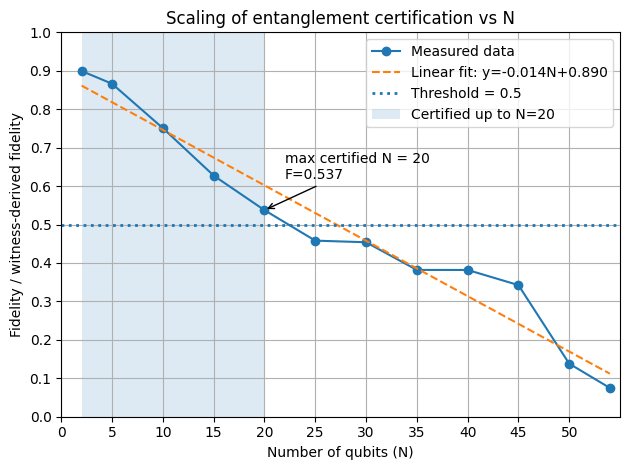

Saved:
 - results\figures\fidelity_vs_n.png
 - results\figures\fidelity_vs_n.pdf
 - results\tables\fidelity_vs_n.csv
 - results\tables\fit_and_threshold.csv


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path


data = {
    2: 0.8994140625,
    5: 0.8662109375,
    10: 0.7507595486111112,
    15: 0.6273716517857143,
    20: 0.5374177631578947,
    25: 0.4580891927083333,
    30: 0.4538995150862069,
    35: 0.38192210477941174,
    40: 0.3817858573717949,
    45: 0.3424627130681818,
    50: 0.13805404974489796,
    54: 0.07488207547169812
}

threshold = 0.5  # common GME threshold 
df = pd.DataFrame({"N": list(data.keys()), "fidelity_lb": list(data.values())}).sort_values("N")
x = df["N"].to_numpy()
y = df["fidelity_lb"].to_numpy()
if len(df) >= 2:
    m, b = np.polyfit(x, y, 1)
    y_pred = m * x + b
else:
    m, b = np.nan, np.nan
    y_pred = None
cert_mask = y > threshold
max_cert_N = int(x[cert_mask].max()) if cert_mask.any() else None

plt.figure()

# data 
plt.plot(x, y, marker="o", linestyle="-", label="Measured data")

# regression line
if y_pred is not None:
    plt.plot(x, y_pred, linestyle="--", label=f"Linear fit: y={m:.3f}N+{b:.3f}")

# threshold line
plt.axhline(threshold, linestyle=":", linewidth=2, label=f"Threshold = {threshold}")

# region shading
if max_cert_N is not None:
    plt.axvspan(x.min(), max_cert_N, alpha=0.15, label=f"Certified up to N={max_cert_N}")
    idx = np.where(x == max_cert_N)[0][0]
    plt.annotate(
        f"max certified N = {max_cert_N}\nF={y[idx]:.3f}",
        xy=(x[idx], y[idx]),
        xytext=(x[idx] + 2, min(0.95, y[idx] + 0.08)),
        arrowprops=dict(arrowstyle="->")
    )

# axes labels/title
plt.xlabel("Number of qubits (N)")
plt.ylabel("Fidelity / witness-derived fidelity")
plt.title("Scaling of entanglement certification vs N")
plt.grid(True)
plt.legend()

plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xlim(0, 55)
plt.xticks(np.arange(0, 55, 5))

plt.tight_layout()

# plot and table export
outdir = Path("results")
(outdir / "figures").mkdir(parents=True, exist_ok=True)
(outdir / "tables").mkdir(parents=True, exist_ok=True)

png_path = outdir / "figures" / "fidelity_vs_n.png"
pdf_path = outdir / "figures" / "fidelity_vs_n.pdf"
csv_path = outdir / "tables" / "fidelity_vs_n.csv"
fit_path = outdir / "tables" / "fit_and_threshold.csv"

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")

df.to_csv(csv_path, index=False)

pd.DataFrame([{
    "slope": m,
    "intercept": b,
    "threshold": threshold,
    "max_certified_N": max_cert_N,
    "num_points": len(df)
}]).to_csv(fit_path, index=False)

plt.show()

print("Saved:")
print(f" - {png_path}")
print(f" - {pdf_path}")
print(f" - {csv_path}")
print(f" - {fit_path}")


## Final experiment: Hardware-optimized GHZ entanglement on IQM Emerald

Before, we briefly mentioned Emerald, but in our attempt to entangle more qubits, the best place to look would be at the core of the problem...

For context, IQM Emerald is based on superconducting transmon qubits arranged in a square lattice with **CZ as the native two-qubit gate** and parameterized X/Y rotations (PRX) as native single-qubit gates.

In previous sections, GHZ states were constructed using CNOT (CX) gates. However, since CX is not native to Emerald, each CX must be decomposed into multiple single-qubit rotations and a CZ gate which unfortunately increases circuit depth and accelerates decoherence, especially for the global coherence observable ⟨X^{⊗N}⟩.

Here, we try to better match the hardware specifications of Emerald, so we constructed the GHZ state directly using CZ gates via the identity:
$$
\text{CNOT}_{i,j} = (I \otimes H)\,\text{CZ}_{i,j}\,(I \otimes H),
$$
so that the entangling operation is implemented natively on the device.

We then further instruct the transpiler to:

• optimize gate count and depth  
• respect the square-lattice topology  
• minimize SWAP operations  

by using SABRE layout and routing with the highest optimization level, and then we then compare the witness values, circuit depth, and CZ gate count to verify that the circuit has been optimized for IQM Emerald.


In [20]:
from qiskit import QuantumCircuit, transpile
import pandas as pd
from pathlib import Path

# CZ-GHZ construction
def getGhzCircuit_cz(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.h(i+1)
        qc.cz(i, i+1)
        qc.h(i+1)
    return qc


# circuitry
qBits = 54 # prev value
shots = 1024 # prev value

qcz_opt = getGhzCircuit_cz(qBits)
qcz_opt.measure_all()

qcx_opt = getGhzCircuit_cz(qBits)
for i in range(qBits):
    qcx_opt.h(i)
qcx_opt.measure_all()

# emerald transpilation
qc_transpiled_z_opt = transpile(
    qcz_opt,
    backend=backend,
    optimization_level=3,
    layout_method="sabre",
    routing_method="sabre",
    seed_transpiler=7
)

qc_transpiled_x_opt = transpile(
    qcx_opt,
    backend=backend,
    optimization_level=3,
    layout_method="sabre",
    routing_method="sabre",
    seed_transpiler=7
)

job_z_opt = backend.run(qc_transpiled_z_opt, shots=shots)
result_z_opt = job_z_opt.result()

job_x_opt = backend.run(qc_transpiled_x_opt, shots=shots)
result_x_opt = job_x_opt.result()

# witness computation
zz_sum_opt = 0
for i in range(qBits - 1):
    zz_sum_opt += getZZExpectation(result_z_opt.get_counts(), i, i + 1, shots)

zz_avg_opt = zz_sum_opt / (qBits - 1)
x_val_opt = getGlobalXExpectation(result_x_opt.get_counts(), shots)
fidelity_lb_opt = 0.5 * (x_val_opt + zz_avg_opt)

print("\nHardware-optimized GHZ results:")
print(f"zz_avg = {zz_avg_opt}")
print(f"x_val  = {x_val_opt}")
print(f"fidelity lower bound = {fidelity_lb_opt}")

# Circuit metrics 
ops_z = qc_transpiled_z_opt.count_ops()
ops_x = qc_transpiled_x_opt.count_ops()

depth_z = qc_transpiled_z_opt.depth()
depth_x = qc_transpiled_x_opt.depth()

print("\nTranspiled circuit metrics:")
print("Z circuit depth:", depth_z)
print("X circuit depth:", depth_x)
print("Z ops:", ops_z)
print("X ops:", ops_x)

# other metrics
outdir = Path("results/tables")
outdir.mkdir(parents=True, exist_ok=True)

row = {
    "N": qBits,
    "shots": shots,
    "zz_avg": zz_avg_opt,
    "x_val": x_val_opt,
    "fidelity_lb": fidelity_lb_opt,
    "depth_Z": depth_z,
    "depth_X": depth_x,
    "ops_Z": str(dict(ops_z)),
    "ops_X": str(dict(ops_x)),
    "note": "cz_native_optimized"
}

metrics_path = outdir / "hardware_optimized_runs.csv"

df_row = pd.DataFrame([row])
if metrics_path.exists():
    df_prev = pd.read_csv(metrics_path)
    pd.concat([df_prev, df_row], ignore_index=True).to_csv(metrics_path, index=False)
else:
    df_row.to_csv(metrics_path, index=False)

print(f"\nSaved hardware-optimized metrics to {metrics_path}")


Progress in queue:   0%|          | 0/6 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/5 [00:00<?, ?it/s]


Hardware-optimized GHZ results:
zz_avg = 0.36147553066037735
x_val  = 0.029296875
fidelity lower bound = 0.19538620283018868

Transpiled circuit metrics:
Z circuit depth: 216
X circuit depth: 216
Z ops: OrderedDict([('r', 236), ('cz', 129), ('measure', 54), ('barrier', 1)])
X ops: OrderedDict([('r', 274), ('cz', 129), ('measure', 54), ('barrier', 1)])

Saved hardware-optimized metrics to results\tables\hardware_optimized_runs.csv


## Interpretation of the hardware-optimized results based on IQM Emerald

For the hardware-optimized run at $N = 54$ qubits, we obtained:
$$
\begin{align}
\text{zz\_avg} &\approx 0.361 \\
\langle X^{\otimes N} \rangle &\approx 0.029 \\
F_{LB} &\approx 0.195
\end{align}
$$

The transpiled circuits required approximately:
$$
\begin{align}
\text{CZ count} &\approx 129 \\
\text{Circuit depth} &\approx 216
\end{align}
$$

From these values, we noticed 2 important things:

- The nearest-neighbor parity correlations $\text{zz\_avg}$ remained finite, so many qubits were still aligned in patterns close to $00\ldots0$ or $11\ldots1$.

- The global coherence term $\langle X^{\otimes N} \rangle$ was strongly supressed, and it meant that phase coherence between the two GHZ branches has largely decayed.

As a result, the prepared state is well approximated by the classical correlated mixture
$$
\begin{align}
\rho \approx \tfrac12 \left( 
|0^{\otimes N}\rangle\langle 0^{\otimes N}| 
+ 
|1^{\otimes N}\rangle\langle 1^{\otimes N}| 
\right).
\end{align}
$$

Although our newer implementation uses the native CZ gate of IQM Emerald and reduces logical gate overhead, the circuit still requires a large number of entangling operations and has substantial depth, so at this scale, accumulated decoherence dominates the dynamics and suppresses the global coherence observable.

Compared to the non-optimized (CX-based) implementation, the hardware-optimized circuit demonstrates a measureable improvement from device aware compilation by yielding a higher fidelity lower bound at $N = 54$, but this improvement is insufficient to preserve large-scale GHZ coherence.


So, maybe the "Secret Sauce" of quantum computing was the friends we made along the way... or with our statistics of two similar but parametrically different approaches, but with the results of our second experiment showing reliable Fidelity values at the 20-qubit range and the help of IQM Emerald, maybe we've unsecreted a bit more about this secret today. Take that, Curmudgeon.